# Using manipulated data

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tick
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
import os
from scipy.optimize import minimize_scalar

In [4]:
# Set global font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'Georgia']
plt.rcParams['font.size'] = 14

In [5]:
def simulate_markov_chain(P, num_steps, start_state=0, sc = 0.01):
    """
    Simulate a Markov chain given a transition matrix P.
    
    Parameters:
    - P: Transition matrix (2D numpy array)
    - num_steps: Number of steps to simulate
    - start_state: Initial state (default is 0)
    
    Returns:
    - List of states over time
    """
    np.random.seed(0)
    # Ensure the matrix is a numpy array
    P = np.array(P)
    
    # Initialize the current state and the list to store the sequence of states
    current_state = start_state
    states = [current_state]
    Values = np.array([-sc, sc])
    # Simulate the Markov chain
    for _ in range(num_steps):
        next_state = np.random.choice(len(P), p=P[current_state])
        states.append(next_state)
        current_state = next_state
    val = [Values[s] for s in states]    
    return val

## Read data

In [6]:
stock = 'AMZN'
lob_level = 1
p = 'lobdataread'
msgfile = os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_message_{lob_level}.csv')
obfile =  os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_orderbook_{lob_level}.csv')
df1=pd.read_csv(msgfile, sep=',', header=None, 
        names=['time', 'type', 'ord_id', 'size', 'price', 'dir'],
        dtype={'time':np.float64, 'type':np.int32, 'ord_id':np.int32, 
               'size':np.int64, 'price':np.int64, 'dir':np.int32})

df2=pd.read_csv(obfile, sep=',', header=None, 
        names=['ask_prc_L1', 'ask_sz_L1', 'bid_prc_L1', 'bid_sz_L1'],
        dtype={'ask_prc_L1':np.float64, 'ask_sz_L1':np.int64, 'bid_prc_L1':np.float64, 'bid_sz_L1':np.int64})

df3 = pd.concat([df1, df2], axis=1)
df3 = df3.drop_duplicates(subset='time', keep='first')
df3['mid_price'] = (df3['ask_prc_L1'] + df3['bid_prc_L1'])/2
df3['datetime'] = pd.to_timedelta(df3['time'], unit='s') + pd.Timestamp("2012-06-21")
df3 = df3[(df3['datetime'].dt.time >= pd.Timestamp('2012-06-21 09:46:00').time()) & 
                 (df3['datetime'].dt.time <= pd.Timestamp('2012-06-21 15:44:00').time())]

In [7]:
df = df3[['time', 'datetime', 'mid_price']].copy()
df['mid_price'] = df['mid_price']/10000 
df.loc[:, 'mid_price'] = df['mid_price'] - df['mid_price'].iloc[0]
df.loc[:, 'time'] = df['time'] - df['time'].iloc[0]
df.reset_index(drop=True, inplace=True)
df['mid_diff'] = df['mid_price'].diff()
# Replace NaN with 0 at the beginning
df['mid_diff'].fillna(0, inplace=True)
threshold = 1e-6
df = df[df['mid_diff'].abs() >= threshold]
df.reset_index(drop=True, inplace=True)

In [8]:
df.head(2)

,time,datetime,mid_price,mid_diff
0,3.364486,2012-06-21 09:46:05.948977122,-0.015,-0.015
1,3.364625,2012-06-21 09:46:05.949116138,-0.020,-0.005


In [9]:
n_state = [3, 3]
n_state_neg = n_state[0]
n_state_pos = n_state[1]
n_state_tot = sum(n_state)

# Split data into positive and negative
df_positive = df[df['mid_diff'] >= 0]
df_negative = df[df['mid_diff'] < 0]

quantiles_values = np.linspace(0, 1, n_state_pos + 1 )[1:-1]
quantiles_values = [int(x) for x in np.round(quantiles_values * 100)]
# Calculate quantiles for positive and negative data
quantiles_positive = df_positive['mid_diff'].quantile(list(np.linspace(0, 1, n_state_pos + 1 )[1:-1])).tolist()
quantiles_negative = df_negative['mid_diff'].quantile(list(np.linspace(0, 1, n_state_neg + 1 )[1:-1])).tolist()

# Remove duplicates
quantiles_positive = sorted(list(set(quantiles_positive)))
quantiles_negative = sorted(list(set(quantiles_negative)))

# Calculate state values a(i) for positive data
a_positive = []
a_positive.append(df_positive[(df_positive['mid_diff'] <= quantiles_positive[0])]['mid_diff'].mean())
for i in range(len(quantiles_positive) - 1):
    a_positive.append(df_positive[(df_positive['mid_diff'] > quantiles_positive[i]) & 
                                  (df_positive['mid_diff'] <= quantiles_positive[i+1])]['mid_diff'].mean())
a_positive.append(df_positive[(df_positive['mid_diff'] > quantiles_positive[-1])]['mid_diff'].mean())


# Calculate state values a(i) for negative data
a_negative = []
a_negative.append(df_negative[(df_negative['mid_diff'] < quantiles_negative[0])]['mid_diff'].mean())
for i in range(len(quantiles_negative) - 1):
    a_negative.append(df_negative[(df_negative['mid_diff'] >= quantiles_negative[i]) & 
                                  (df_negative['mid_diff'] < quantiles_negative[i+1])]['mid_diff'].mean())
a_negative.append(df_negative[(df_negative['mid_diff'] >= quantiles_negative[-1])]['mid_diff'].mean())


In [10]:
plt.figure(figsize=(10,5))
plt.hist(df_positive["mid_diff"], bins=30, alpha=0.7, label='Histogram of positive mid_diff')

# Add vertical lines for quantiles
for i, q in enumerate(quantiles_positive):
    plt.axvline(q, color='r', linestyle='--', label=f'{quantiles_values[i]}% Quantile: {q:.4f}')

# Add vertical lines for the specified values
for i, v in enumerate(a_positive):
    plt.axvline(v, color='g', linestyle=':', label=f'a({i + 4}): {v:.4f}')

plt.legend()
plt.xlabel('Price change')
plt.ylabel('Frequency')
plt.title('Histogram of price change with Quantiles for positive values')
plt.tight_layout()
plt.savefig("./pics/aapl_quant_pos_ns.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
plt.figure(figsize=(10,5))
plt.hist(df_negative["mid_diff"], bins=30, alpha=0.7, label='Histogram of positive mid_diff')

# Add vertical lines for quantiles
for i, q in enumerate(quantiles_negative):
    plt.axvline(q, color='r', linestyle='--', label=f'{quantiles_values[i]}% Quantile: {q:.4f}')

# Add vertical lines for the specified values
for i, v in enumerate(a_negative):
    plt.axvline(v, color='g', linestyle=':', label=f'a({i + 1}): {v:.4f}')

plt.legend()
plt.xlabel('Price change')
plt.ylabel('Frequency')
plt.title('Histogram of price change with Quantiles for negative values')
plt.tight_layout()
plt.savefig("./pics/aapl_quant_neg_ns.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Assign states to price changes
df['state'] = np.nan

# Assign states for negative data
df.loc[df['mid_diff'] < quantiles_negative[0], 'state'] = 0
df.loc[df['mid_diff'] < quantiles_negative[0], 'state_value'] = a_negative[0]
for i in range(1, len(quantiles_negative)):
    df.loc[(df['mid_diff'] >= quantiles_negative[i-1]) & (df['mid_diff'] < quantiles_negative[i]), 'state'] = i
    df.loc[(df['mid_diff'] >= quantiles_negative[i-1]) & (df['mid_diff'] < quantiles_negative[i]), 'state_value'] = a_negative[i]
df.loc[(df['mid_diff'] >= quantiles_negative[-1])  & (df['mid_diff'] < 0), 'state'] = len(quantiles_negative)
df.loc[(df['mid_diff'] >= quantiles_negative[-1])  & (df['mid_diff'] < 0), 'state_value'] = a_negative[-1]
    
    
start_state_pos = len(a_negative) 
df.loc[(df['mid_diff'] <= quantiles_positive[0]) & (df['mid_diff'] >= 0) , 'state'] = start_state_pos 
df.loc[(df['mid_diff'] <= quantiles_positive[0]) & (df['mid_diff'] >= 0), 'state_value'] = a_positive[0]
for i in range(1, len(quantiles_positive)):
    df.loc[(df['mid_diff'] > quantiles_positive[i - 1]) & (df['mid_diff'] <= quantiles_positive[i]), 'state'] = start_state_pos + i
    df.loc[(df['mid_diff'] > quantiles_positive[i - 1]) & (df['mid_diff'] <= quantiles_positive[i]), 'state_value'] = a_positive[i]
df.loc[df['mid_diff'] > quantiles_positive[-1], 'state'] = start_state_pos + len(quantiles_positive)
df.loc[df['mid_diff'] > quantiles_positive[-1], 'state_value'] =  a_positive[-1]
df['state'] = df['state'].astype(int)

In [13]:
df.head()

,time,datetime,mid_price,mid_diff,state,state_value
0,3.364486,2012-06-21 09:46:05.948977122,-0.015,-0.015,0,-0.028456
1,3.364625,2012-06-21 09:46:05.949116138,-0.020,-0.005,2,-0.005000
2,3.956853,2012-06-21 09:46:06.541343511,-0.015,0.005,3,0.005000
3,3.957027,2012-06-21 09:46:06.541517876,-0.005,0.010,4,0.009945
4,3.957593,2012-06-21 09:46:06.542084016,-0.015,-0.010,1,-0.009962


In [14]:
df.isnull().any()

time           False
datetime       False
mid_price      False
mid_diff       False
state          False
state_value    False
dtype: bool

In [15]:
df = df[['time', 'datetime', 'mid_diff', 'mid_price', 'state', 'state_value']]

In [16]:
df.head(2)

,time,datetime,mid_diff,mid_price,state,state_value
0,3.364486,2012-06-21 09:46:05.948977122,-0.015,-0.015,0,-0.028456
1,3.364625,2012-06-21 09:46:05.949116138,-0.005,-0.020,2,-0.005000


In [17]:
%matplotlib inline
#df.mid_price.plot()

In [18]:
timestamps_list = [df['time'].values]
# Define a function to compute the negative hawkes score for a given decay
def negative_hawkes_score(decay):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000, tol=1e-10)
    hawkes_learner.fit(timestamps_list)
    return -hawkes_learner.score()

# Use minimize_scalar to find the decay that minimizes the negative hawkes score
result = minimize_scalar(negative_hawkes_score, bounds=(500, 5000), method='bounded')

# Extract the optimal decay and the maximum hawkes score from the result
optimal_decay = result.x
max_score = -result.fun

print("Optimal Decay Value:", optimal_decay)
print("Maximum Hawkes Score:", max_score)
best_hawkes = HawkesExpKern(optimal_decay, verbose=False, max_iter=10000, tol=1e-10)
best_hawkes.fit(timestamps_list)
best_decay = optimal_decay
best_score = best_hawkes.score()

Optimal Decay Value: 1205.7552168460784
Maximum Hawkes Score: 692.9856742937149


In [19]:
print(f'n = {best_hawkes.n_nodes}',
      f'mu = {best_hawkes.baseline}', 
      f'alpha = {best_hawkes.adjacency}', '\n'
      f'beta = {best_decay}, alpha_p = {best_hawkes.adjacency * best_decay}, score = {best_score}')

n = 1 mu = [0.3808394] alpha = [[0.64147762]] 
beta = 1205.7552168460784, alpha_p = [[773.46499037]], score = 692.9856742937149


## Markov Process

## Transition probability

In [20]:
# Initialize transition matrix
transition_matrix = np.zeros((n_state_tot, n_state_tot))

# Compute transitions
for i in range(len(df['state']) - 1):
    current_state = df['state'].iloc[i]
    next_state = df['state'].iloc[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_probs = transition_matrix / transition_matrix.sum(axis=1)[:, None]
print(transition_probs)

[[0.10263236 0.12806862 0.18101154 0.08429459 0.09878734 0.40520556]
 [0.11722816 0.15064366 0.21172282 0.09504245 0.31909066 0.10627225]
 [0.11919784 0.15930599 0.215863   0.33415953 0.08922938 0.08224425]
 [0.08268616 0.08474189 0.34856099 0.22019187 0.15303792 0.11078118]
 [0.09101092 0.36544385 0.08933072 0.19686362 0.14813778 0.10921311]
 [0.41812161 0.08579169 0.07555689 0.17940999 0.1435882  0.09753161]]


In [21]:
# Assuming transition_probs is your transition matrix
P = transition_probs

# Create a matrix where each row is P - I
matrix = P.T - np.eye(P.shape[0])

# Replace the last row with ones to account for the probability constraint
matrix[-1, :] = 1

# Create the target vector, with a 1 at the end for the probability constraint
target = np.zeros(P.shape[0])
target[-1] = 1

# Solve the linear system
stationary_probs = np.linalg.solve(matrix, target)

print(stationary_probs)
print("================")
print(stationary_probs @ P)
print("================")
print(np.sum(stationary_probs))

[0.14862596 0.16054869 0.19520363 0.19252834 0.15702904 0.14606435]
[0.14862596 0.16054869 0.19520363 0.19252834 0.15702904 0.14606435]
1.0


In [22]:
float_list = [0.14862596, 0.16054869, 0.19520363, 0.19252834, 0.15702904, 0.14606435]
" &".join([f"{number:.3f}" for number in float_list])


'0.149 &0.161 &0.195 &0.193 &0.157 &0.146'

## General compound

\begin{equation}
v(i) = b(i)^2 + \sum_{j \in S} (g(j) - g(i))^2 P(i, j) - 2b(i) \sum_{j \in S} (g(j) - g(i)) P(i, j)
\end{equation}

In [23]:
def compute_v(b, g, P):
    """
    Compute v based on the given formula.
    
    Parameters:
    - i: the current state
    - b: a function or dictionary that gives b(i) for each i
    - g: a function or dictionary that gives g(i) for each i
    - P: a 2D array or dictionary of dictionaries that gives P(i, j) for each pair i, j    
    Returns:
    - v
    """
    v = np.zeros(b.shape)
    S = np.array([i for i in range(len(b))])
    for i in range(len(b)):
        term1 = b[i]**2
        term2 = np.sum([(g[j] - g[i])**2 * P[i][j] for j in S])
        term3 = -2 * b[i] * np.sum([(g[j] - g[i]) * P[i][j] for j in S])
        v[i] = term1 + term2 + term3
    
    return v

In [24]:
# np.dot(stationary_probs, transition_probs), stationary_probs

In [25]:
lam = best_hawkes.baseline
alpha = best_hawkes.adjacency
beta = best_decay
mu_hat = alpha# (alpha*beta)/beta
a = a_negative + a_positive
a_star = np.dot(stationary_probs, a)
b = a - a_star
# # compute g 
P = transition_probs
Pi = np.tile(stationary_probs, (len(stationary_probs), 1))
# Identity matrix
I = np.eye(n_state_tot)
# Compute the inverse of P + Pi - I
g = np.linalg.inv(P + Pi - I)@ b
v =compute_v(b, g, P) 
sigma_2 = np.dot(stationary_probs, v)
sigma = np.sqrt(sigma_2)
sigma_star = sigma * np.sqrt(lam / (1 - mu_hat))

In [26]:
transition_probs, sigma, a_star, mu_hat, lam

(array([[0.10263236, 0.12806862, 0.18101154, 0.08429459, 0.09878734,
         0.40520556],
        [0.11722816, 0.15064366, 0.21172282, 0.09504245, 0.31909066,
         0.10627225],
        [0.11919784, 0.15930599, 0.215863  , 0.33415953, 0.08922938,
         0.08224425],
        [0.08268616, 0.08474189, 0.34856099, 0.22019187, 0.15303792,
         0.11078118],
        [0.09101092, 0.36544385, 0.08933072, 0.19686362, 0.14813778,
         0.10921311],
        [0.41812161, 0.08579169, 0.07555689, 0.17940999, 0.1435882 ,
         0.09753161]]),
 0.01329614920120541,
 -0.0001065650938421132,
 array([[0.64147762]]),
 array([0.3808394]))

In [27]:
"& ".join([(f'{x:.3f}') for x in a])

'-0.028& -0.010& -0.005& 0.005& 0.010& 0.029'

In [28]:
"& ".join([(f'{x:.3f}') for x in stationary_probs.tolist() + [sigma] + mu_hat[0].tolist()])

'0.149& 0.161& 0.195& 0.193& 0.157& 0.146& 0.013& 0.641'

In [29]:
df['mid_price2'] = np.cumsum(df['state_value'])
df['datetime'] = pd.to_datetime(df['datetime'])

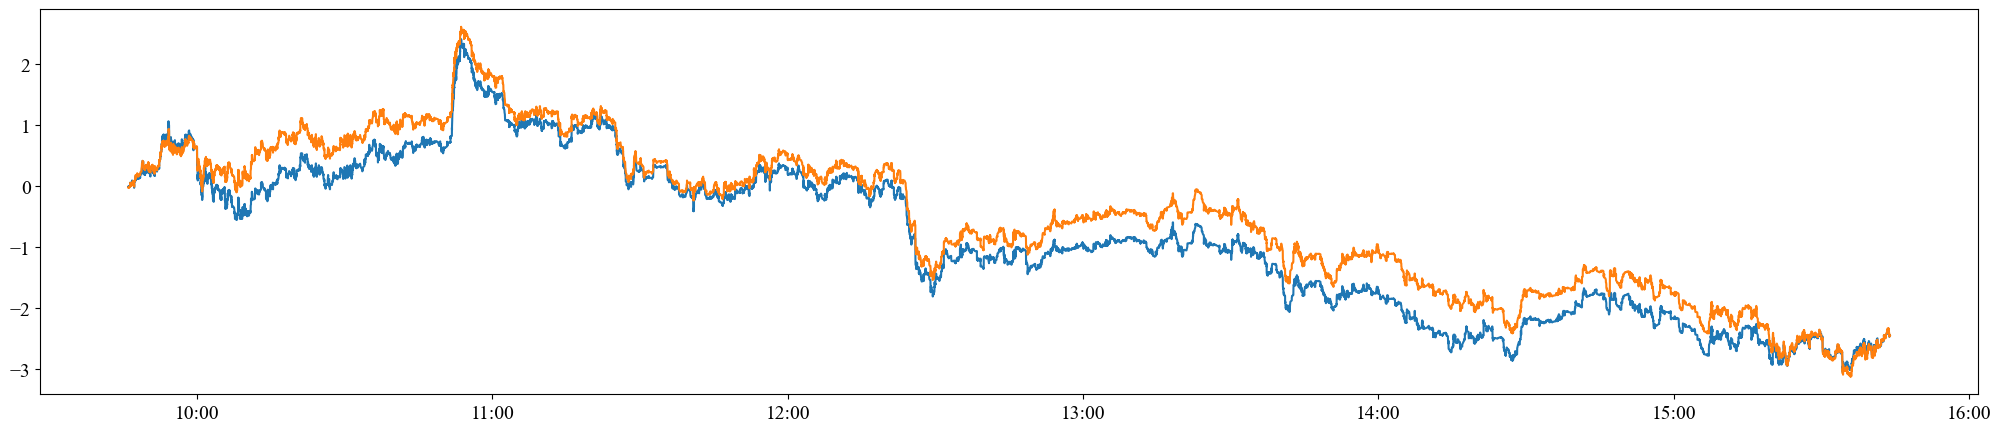

In [30]:
%matplotlib inline
import matplotlib
fig, ax = plt.subplots(1,1, figsize  = (25,5))
ax.plot(df.datetime, df.mid_price)
ax.plot(df.datetime, df.mid_price2)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
#ax.set_xlim([0, 21400])
#ax.set_ylim([-5, 2])

In [31]:
df.tail(2)

,time,datetime,mid_diff,mid_price,state,state_value,mid_price2
22740,21469.625623,2012-06-21 15:43:52.210113909,0.005,-2.440,3,0.005,-2.440
22741,21470.779758,2012-06-21 15:43:53.364248969,-0.005,-2.445,2,-0.005,-2.445


In [32]:
df_ = df
df_ = df.set_index('datetime')
windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
std_values = {}
std_values_theory = {}
for window in windows:
    window = str(window) + 'S'
    mid_price =  df_['mid_price'].resample(window).apply(lambda x: x[-1] - x[0])
    jump = df_['mid_price'].resample(window).size() * a_star
    p_result = mid_price - jump
                  
    std_value = p_result.dropna().std()
    std_values[window] = std_value
    n = float(window.replace('S',''))
    std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()

# Plotting the results
#std_values, std_values_theory
x = [int(key[:-1]) for key in std_values.keys()]
y = list(std_values.values())
# Fit 2nd order polynomial
z2 = np.polyfit(x, y, 2)
p2 = np.poly1d(z2)

# Fit 3rd order polynomial
z3 = np.polyfit(x, y, 3)
p3 = np.poly1d(z3)

In [33]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
def mycurvefit(std_values, std_values_theory):
    x = [int(key[:-1]) for key in std_values.keys()]
    y = list(std_values.values())

    def func(x, a, b):
        return a * np.sqrt(x) + b
    params, covariance = curve_fit(func, x, y)
    a, b = params
    y_pred = func(x, a, b)
    y_true = list(std_values_theory.values())
    #y_signal = y
    return  y_pred, y_true, a, b
y_pred, y_true, a, b = mycurvefit(std_values, std_values_theory)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(rmse)
print("& ".join(map(str, [a, b, rmse])))

0.1299751943692631
0.015094125721120169& 0.09175139562949873& 0.1299751943692631


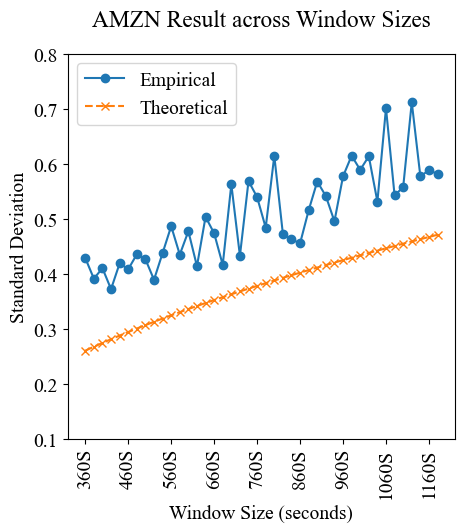

In [36]:
# Plotting the results
plt.figure(figsize=(5, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('AMZN Result across Window Sizes', y= 1.05)
plt.legend()
n = 5
keys = list(std_values.keys())
plt.xticks(keys[::n], keys[::n], rotation=90)
plt.ylim([.1, 0.8])

#plt.xticks(rotation=90)

plt.savefig("./pics/amzn_std_ns.png", dpi=300, bbox_inches='tight')
#plt.grid(True)
plt.show()

In [39]:
ll = np.array([list(std_values_theory.keys()), list(std_values_theory.values())])
ll[:2,:2]

array([['360S', '380S'],
       ['0.26000992980315163', '0.26713480869825473']], dtype='<U32')